Copyright 2021 QHBM library authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2021 QHBM library authors, All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Modular Hamiltonian Learning tutorial

In this demo, we will learn how to use a Quantum Modular Hamiltonian Learning model, discussing both the analytical calculation and the numerical implementation of a minimal example. In it, we will have a target distribution $ \hat{\sigma}_D$ that we will try to approximate with a hypothesis distribution $\hat{\rho}_{\theta\phi}$.

The target distribution $\hat{\sigma}_D$ is spanned by a Bernoulli random variable together with an ansatz consisting solely of an $R_Y$ gate. We will try to approximate the resulting distribution with our hypothesis distribution $\hat{\rho}_{\theta\phi}$, which will be spanned by a Bernoulli random variable together with an ansatz consisting solely of an $R_X$ gate. The keen observer would note that the ansatz used for the target distribution (Ry gate) does not match the ansatz used for our hypothesis distribution (Rx gate). This was a deliberate choice, as often in real scenarios, the target distribution is unknown, and an inductive bias cannot be avoided.

For more information, see [the paper](arXiv:1910.02071) that this notebook accompanies: <br>
"Verdon, Guillaume, Jacob Marks, Sasha Nanda, Stefan Leichenauer, and Jack Hidary. "Quantum hamiltonian-based models and the variational quantum thermalizer algorithm." arXiv:1910.02071 (2019)."

## Initial setup

Before we truly get started, we will define the required software packages, initalizes some variables, and define our target mixed state $\sigma_D$.

### Define the required packages
We will make use of cirq, tensorflow, tensorflow quantum and tensorflow probability, as well as the qhbm library. They are all installed when you pip install qhbmlib. 

In [2]:
!pip install -q qhbmlib==0.2.1

import math
import cirq
import sympy
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

from qhbmlib import ebm
from qhbmlib import qhbm
from qhbmlib import qmhl
from qhbmlib import qnn
from qhbmlib import util

tfd = tfp.distributions

### Initial variables
In this section, we choose basic hyper-parameters of our setup, such as the number of qubits used. In our example, we will stick to a single-qubit scenario. If one were to extend our example to a multi-qubit scenario, the resulting system would be a tensor-product of single-qubit systems. However, it should be noted that, for the general case, the Quantum Hamiltonian-Based Model can model any density matrix given an appropriate ansatz.

In [3]:
# the size of the system we will use
num_qubits = 1
# our seed, 42
seed = ord("*")
num_data_samples = 1e6

### Creating data for mixed target state $\sigma_D$
We will generate the data samples of our target mixed state $\sigma_D$ in the form of quantum circuits by using the quantum hamiltonian based model structure:

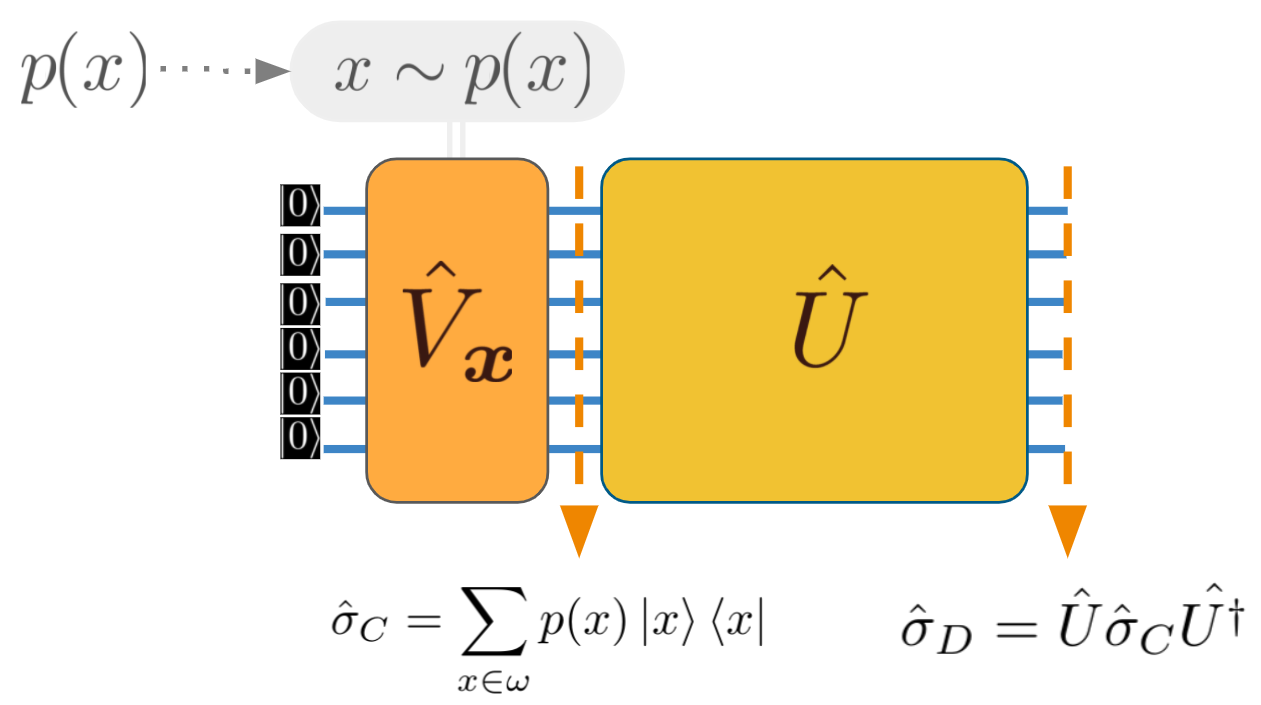

 This model consists of two main components. A diagonal unitary $\hat{V}_x$ that generates the state $\hat{\sigma}_C$ and a unitary $\hat{U}$ that generates the state $\hat{\sigma}_D$. 
 
 The unitary $\hat{V}_x$ uses the samples $x$ drawn from probability distribution $p$ in order to initialize the state $|x\rangle\langle x|$ with probability $p(x)$. The resulting state can be described as
 
\begin{align}
 \hat{\sigma}_C 
 &= \sum p(x) |x\rangle\langle x| 
 = p(0) |0\rangle\langle 0| + p(1) |1\rangle\langle 1| 
 = \begin{bmatrix} p_0 & 0 \\ 0 & p_1 \end{bmatrix}
\end{align} 

The unitary $\hat{U}$ consists of a single $R_Y$ gate, parameterized by $\alpha$. Such a Y rotation can be written in matrix form as (see [Ian Glendinning's notes "Rotations on the Bloch Sphere"](http://www.vcpc.univie.ac.at/~ian/hotlist/qc/talks/bloch-sphere-rotations.pdf)):
$$
R_y(\alpha) = e^{-i\frac{\alpha}{2}Y} = \begin{bmatrix}\cos\frac{\alpha}{2} & -\sin\frac{\alpha}{2}\\\sin\frac{\alpha}{2} & \cos\frac{\alpha}{2}\end{bmatrix}.
$$ 
 
Combining these two yields the overall data state
\begin{align}
\hat{\sigma}_D = \hat{U} \hat{\sigma}_C \hat{U}^\dagger 
&= R_y(\alpha)\begin{bmatrix} p_0 & 0 \\ 0 & p_1 \end{bmatrix}R_y^\dagger(\alpha) \\
&= \begin{bmatrix}p_0\cos^2\frac{\alpha}{2} + p_1\sin^2\frac{\alpha}{2} & p_0\cos\frac{\alpha}{2}\sin\frac{\alpha}{2} - p_1\cos\frac{\alpha}{2}\sin\frac{\alpha}{2}\\ p_0\cos\frac{\alpha}{2}\sin\frac{\alpha}{2} - p_1\cos\frac{\alpha}{2}\sin\frac{\alpha}{2} & p_0\sin^2\frac{\alpha}{2} + p_1\cos^2\frac{\alpha}{2}\end{bmatrix} \\
&= \begin{bmatrix} \sin^2\frac{\alpha}{2} + p_0\cos\alpha & \left(p_0 - \frac{1}{2}\right)\sin\alpha \\ \left(p_0 - \frac{1}{2}\right)\sin\alpha & \cos^2\frac{\alpha}{2} - p_0\cos\alpha \end{bmatrix},
\end{align}
where we used the identities $p_1 = 1 - p_0$, $\cos\alpha = \cos^2\frac{\alpha}
{2} - \sin^2\frac{\alpha}{2}$, and $\frac{1}{2}\sin\alpha = \cos\frac{\alpha}{2}\sin\frac{\alpha}{2}$.

In code, this is implemented as follows

In [4]:
q_const = 2 * math.pi

# draw uniform probabilies p_0 and p_1
data_probs = tf.random.uniform([num_qubits])
# generate samples using the Bernoulli distribution
raw_samples = tfd.Bernoulli(
    probs=1 - data_probs, dtype=tf.int8).sample(num_data_samples)
# In the next step, we cheat a little, calculating only the unique bitstrings
# and multiplying with how often they occured
unique_bitstrings, target_counts = util.unique_bitstrings_with_counts(
    raw_samples)

# define our circuit layout, a 1d stretch of qubits of length num_qubits
qubits = cirq.GridQubit.rect(1, num_qubits)
# sample the parameters for the gates in the Ansatz from the uniform distribution
alphas = tf.random.uniform([num_qubits], minval=-q_const, maxval=q_const)

U = cirq.Circuit(cirq.ry(r.numpy())(q) for r, q in zip(alphas, qubits))
# U acting on |0><0|
p0_circuits = U
# U acting on |1><1| (implemented as X on |0><0|)
p1_circuits = cirq.X(qubits[0]) + U

# convert to tensors
target_states = tfq.convert_to_tensor([p1_circuits, p0_circuits])

## Quantum Hamiltonian Based Model

In this section we will get to the core of the project: approximating the target distribution $\hat{\sigma}_D$ with our hypothesis distribution $\hat{\rho}_{\theta\phi}$. In order to do so, we will make use of Quantum Modular Hamiltonian Learning with a Quantum Hamiltonian Based model. The general architecture of such a model is shown in the image below. Here, we need to define our classical probability distribution $p_\theta(x)$ and our quantum ansatz $\hat{U}(\phi)$. This is a parameterization of the general circuit above that was used to generate $\hat{\sigma}_D$, in which we still have the split of classical correlations captured in $\hat{V}_x$ and quantum correlations in $\hat{U}(\theta)$.





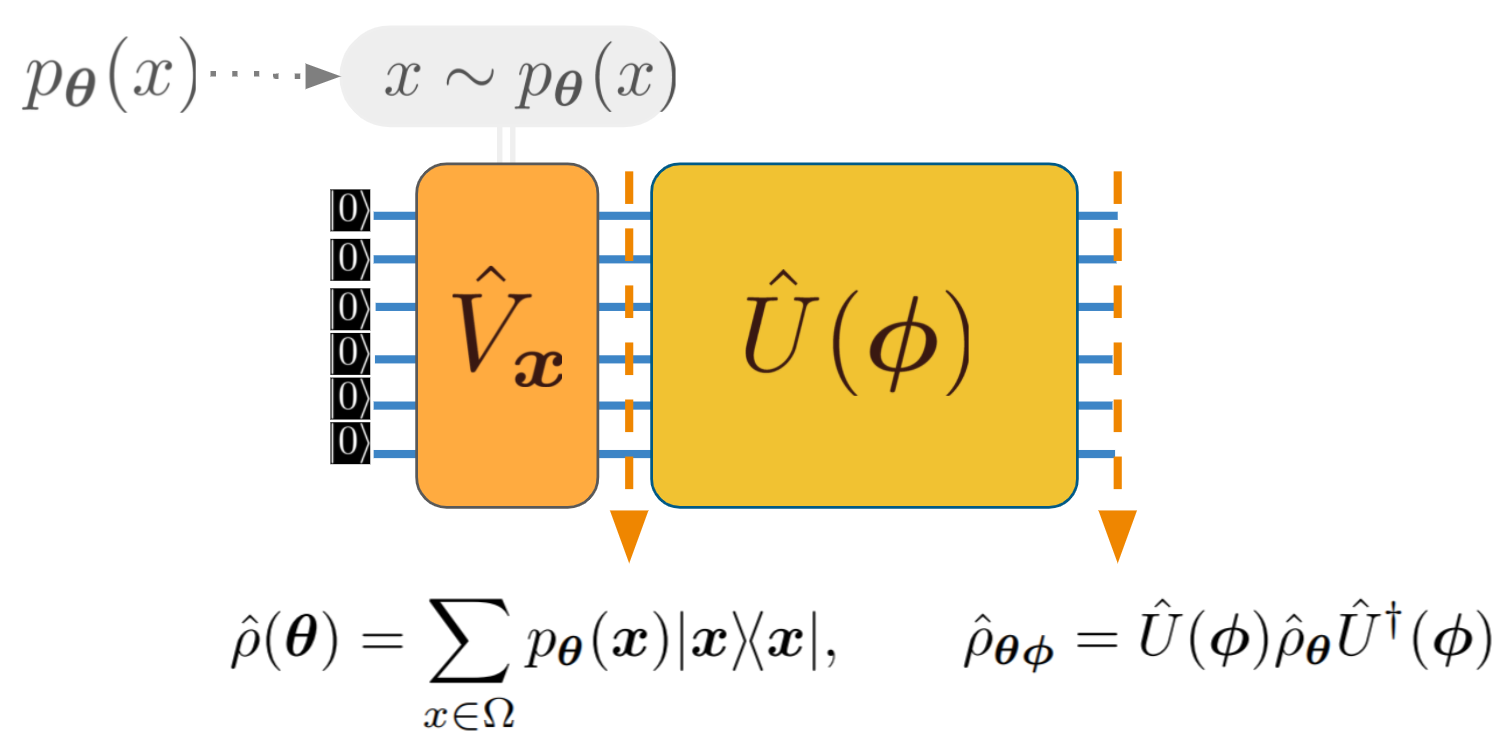

### Define the latent state

The latent state is defined by the sum of the eigenvalues of some density operator

$$\hat{\rho}_\theta \equiv \sum_x p_\theta(x) |x\rangle\langle x|$$

For the right choice of $p_\theta$, this can represent the eigenvalues of any density matrix. It is important to note that we can write this as the exponential of some operator $K$, as this is convenient for taking derivatives and defining loss functions that involve logarithms.

\begin{align}
  \hat{\rho}_\theta &= \sum_{x \in \Omega} \left( \frac{e^{-E_\theta(x)}}{Z_\theta} \right) |x\rangle\langle x| \\
  &= Z_\theta^{-1} e^{-\sum_{x \in \Omega} E_\theta(x) |x\rangle\langle x|} \\
  &= \frac{e^{-\hat{K}_\theta}}{Z_\theta}
\end{align}

where the partition function $Z_\theta$ is given by
$$Z_\theta= \mathrm{Tr}[e^{-\hat{K}_\theta}]$$

For our example, we will make use of a variation of the Bernoulli distribution. The general Bernoulli distribution is given as
$$p_\alpha(x) = \alpha^x (1-\alpha)^{1-x}$$
We re-parameterize the Bernoulli distribution with 
$$\theta = \frac{1}{2}\log \left( \frac{\alpha}{1-\alpha}\right), $$
which corresponds to the energy of a spin $\frac{1}{2}$ particle:  
$$ E_\theta(x) =     
  \begin{cases}
      \theta, & \text{if}\ x=0 \\
      -\theta, & \text{if}\ x=1.
  \end{cases} 
$$

The latent modular Hamiltonian corresponding to a Bernoulli is then given by
\begin{align}
\hat{K}_\theta &= 
\sum_x E_\theta(x) |x\rangle\langle x| \\
&= E_\theta(0) |0\rangle\langle 0| + E_\theta(1) |1\rangle\langle 1| \\
&= \begin{bmatrix} \theta & 0 \\ 0 & -\theta \end{bmatrix}
\end{align}

Using our definition, this yields the following latent state
\begin{align}
\hat{\rho}_\theta &= \frac{e^{-\hat{K}_\theta}}{Z_\theta} = \frac{1}{e^{-\theta} + e^{\theta}}\begin{bmatrix}
    e^{-\theta} & 0 \\
    0 & e^{\theta}
\end{bmatrix}.
\end{align}

An alternative method to derive this is given in appendix "A. Bernoulli distribution".

In code, this can be implemented using the ebm.Bernoulli function: 

In [5]:
# sets the min and max values for the uniform distribution that theta gets drawn from
ebm_const = 2.0
# sample random value(s) to init theta
ebm_init = tf.keras.initializers.RandomUniform(
    minval=-ebm_const, maxval=ebm_const, seed=seed)
# represents either p_\theta or E(theta), depending on which functions you call.
# true refers to calculation of the log$
test_ebm = ebm.Bernoulli(num_qubits, ebm_init, True)

### Define the visible state

To complete the model, we use $\hat{U}(\phi)$ to add the quantum correlations. The evolution of a density matrix under the action of a unitary is written as

$$ \hat{\rho}_{\theta\phi} = \hat{U}(\phi) \hat{\rho}_{\theta} \hat{U}^\dagger(\phi). $$

By taking the log, we can work our way back to the modular Hamiltonian

\begin{align}
  \log(\hat{\rho}_{\theta\phi}) &= \frac{e^{-\hat{K}_{\theta\phi}}}{Z_{\theta\phi}} \\
  &= \log(e^{-\hat{K}_{\theta\phi}}) + \log(Z_{\theta\phi}^{-1}) \\
  &= -\hat{K}_{\theta\phi} - \log(Z_{\theta\phi}).
\end{align}
As 
\begin{align}
 Z_{\theta\phi} &= \mathrm{Tr[e^{-\hat{K}_{\theta\phi}} ]} \\
 &= \mathrm{Tr[\hat{U}(\phi) e^{-\hat{K}_\theta} \hat{U}^\dagger(\phi) )]} \\ 
 &= \mathrm{Tr[\hat{U}^\dagger(\phi) \hat{U}(\phi) e^{-\hat{K}_\theta})]} \\
 &= \mathrm{Tr[e^{-\hat{K}_\theta})]} \\
 &= Z_{\theta}
 \end{align}
we get
$$\hat{K}_{\theta\phi} = -\log \left(\hat{\rho}_{\theta\phi}\right)-\log(Z_\theta)$$

For our example, we will make use of an ansatz that consists solely of a single $R_X$ gate parameterized by $\phi$. This allows our ansatz to be written as
$$
\hat{U}(\phi) = R_x(\phi) = e^{-i\frac{\phi}{2}X} = \begin{bmatrix}\cos\frac{\phi}{2} & -i\sin\frac{\phi}{2}\\-i\sin\frac{\phi}{2} & \cos\frac{\phi}{2}\end{bmatrix}.
$$
In code, the circuit $U(\phi)$ is implemented as follows

In [6]:
# construct cirquit
qubits = cirq.GridQubit.rect(1, num_qubits)
# placeholder variables
r_symbols = [sympy.Symbol(f"phi_{n}") for n in range(num_qubits)]
# place Rx on each qubit
r_circuit = cirq.Circuit(cirq.rx(r_s)(q) for r_s, q in zip(r_symbols, qubits))
# define distribution to initialize variables with
qnn_init = tf.keras.initializers.RandomUniform(
    minval=-q_const, maxval=q_const, seed=seed)
# initialize our ansatz
# true: analytic mode, using state_vector_calculation simulator;
# when you take an expectation value of some Hamiltonian with that QNN,
# it will take the exact inner product
test_qnn = qnn.QNN(r_circuit, qnn_init, is_analytic=True)

Looking back at the definition of the full model visible state, we get for our example 
\begin{align}
 \hat{\rho}_{\theta\phi} &= \hat{U}(\phi) \hat{\rho}_{\theta} \hat{U}^\dagger(\phi) \\
  &= \frac{1}{e^{-\theta} + e^{\theta}} R_x(\phi) \begin{bmatrix}
    e^{-\theta} & 0 \\
    0 & e^{\theta}
  \end{bmatrix} R_x^\dagger(\phi) \\
  &= \frac{1}{e^{-\theta} + e^{\theta}}
  \begin{bmatrix}
    e^{-\theta}\cos^2\frac{\phi}{2} + e^{\theta}\sin^2\frac{\phi}{2} & \frac{1}{2}\left(ie^{-\theta}-ie^{\theta}\right)\sin\phi \\
    \frac{1}{2}\left(ie^{\theta}-ie^{-\theta}\right)\sin\phi & e^{\theta}  \cos^2\frac{\phi}{2} + e^{-\theta}\sin^2\frac{\phi}{2}
  \end{bmatrix},
\end{align}
where I used the identity $\cos\frac{\phi}{2}\sin\frac{\phi}{2} = \frac{1}{2}\sin\phi$. This can be implemented with the qhbm.QHBM function, and providing both the classical and quantum component

In [7]:
# merge the EBM and the QNN together in the model QHBM
# this is the model that we will be training
test_qhbm = qhbm.QHBM(test_ebm, test_qnn)

## Train the model

### Loss function


Now that we have our target distribution $\hat{\sigma}_D$ and our hypothesis distribution $\hat{\rho}_{\theta\phi}$, we need to optimize our parameters $\theta$ and $\phi$ in such a way that our hyptothesis distribution approximates the target distribution as close as possible. During the optimization process, we need to be able to quantify how close our distribution is. A great candidate is calculating the quantum relative entropy

$$D\left(\hat{\sigma}_D \Vert \hat{\rho}_{\theta\phi}\right) =  \mathrm{Tr}\left(\hat{\sigma}_D \log(\hat{\sigma}_D)\right) - \mathrm{Tr}\left(\hat{\sigma}_d \log(\hat{\rho}_{\theta_\phi})\right)$$

We can rewrite the first term as the entropy of the target distribution, and expand upon the second term using our previous calculation of $\hat{K}_{\theta\phi} = -\log \left(\hat{\rho}_{\theta\phi}\right)-\log(Z_\theta)$

\begin{align}
D\left(\hat{\sigma}_D \Vert \hat{\rho}_{\theta\phi}\right) &= -S(\hat{\sigma}_D) - \mathrm{Tr}\left[\hat{\sigma}_D \log(\hat{\rho}_{\theta\phi})\right] \\
D\left(\hat{\sigma}_D \Vert \hat{\rho}_{\theta\phi}\right) &= -S(\hat{\sigma}_D) - \mathrm{Tr}\left[\hat{\sigma}_D \log(\hat{\rho}_{\theta\phi})\right] - \log(\mathcal{Z}_\theta) + \log(\mathcal{Z}_\theta) \\
D\left(\hat{\sigma}_D \Vert \hat{\rho}_{\theta\phi}\right) &= -S(\hat{\sigma}_D) + \mathrm{Tr}\left[\hat{\sigma}_D \left(-\log(\hat{\rho}_{\theta\phi}) - \log(\mathcal{Z}_\theta) \right)\right] + \log(\mathcal{Z}_\theta) \\
D\left(\hat{\sigma}_D \Vert \hat{\rho}_{\theta\phi}\right) &= -S(\hat{\sigma}_D) +  \mathrm{Tr}\left[\hat{\sigma}_D \hat{K}_{\theta\phi}\right] + \log(\mathcal{Z}_\theta)
\end{align}

Here, our first term $S(\hat{\sigma}_D) is independent of our variational parameters an can be safely ignored during the optimization process, allowing us to drop it

$$D\left(\hat{\sigma}_D \Vert \hat{\rho}_{\theta\phi}\right) = \mathrm{Tr}\left(\hat{\sigma}_D \hat{K}_{\theta\phi}\right) + \log(\mathcal{Z}_\theta)$$

The log of our partition function $\mathcal{Z}_\theta$ can be calculated fully classically. The remaining trace term can be rewritten in such a way to clearly show the quantum and classical component by writing

$$ \mathrm{Tr}[\hat{\sigma}_D \hat{K}_{\theta\phi}] = \sum_x p(x)E_\theta(x)= \mathbb{E}[E_\theta(x)]$$

where x are measurements drawn from the concatination of $\hat{\sigma}_D$ and $U^\dagger(\phi)$ using a $Z$-observable on every qubit. The resulting formula can directly be used as our Loss in the optimization process:

$$ \mathcal{L}_{\theta,\phi} \equiv D\left(\hat{\sigma}_D \Vert \hat{\rho}_{\theta_\phi}\right) = \mathbb{E}[E_\theta(x)] + \log(\mathcal{Z}_\theta)$$

When running this on a real quantum system, we can approximate our first term as follows:

$$ \mathbb{E}[E_\theta(x)] \cong \sum_x \frac{N(x)}{N} E_\theta(x) $$


This setup has been shown schematically in the image below. Here, double lines represents components pertaining to the quantum system whereas single lines relate to the classical system. 


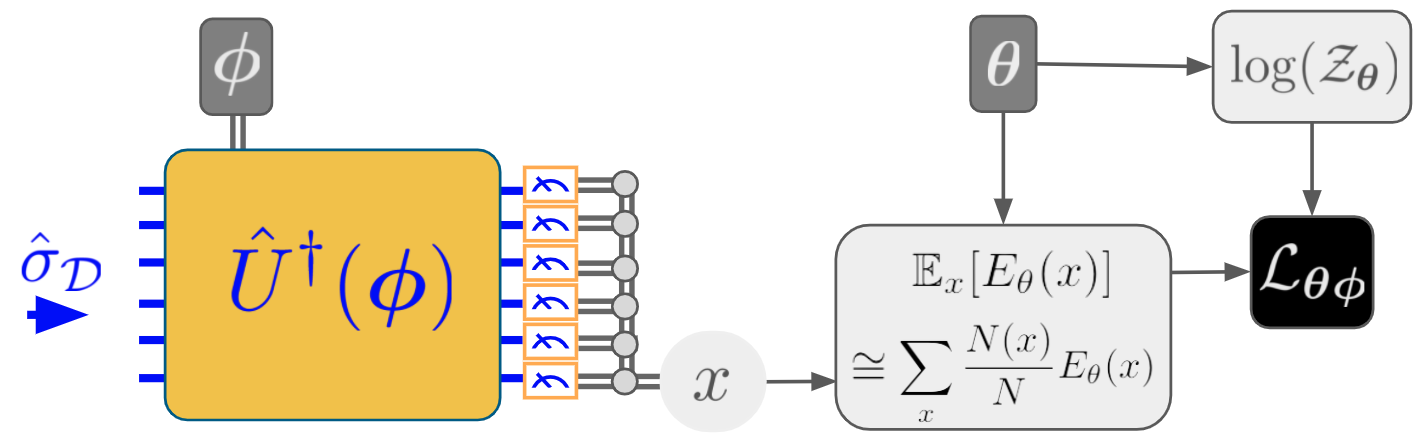

In code, this is implemented as follows

In [8]:
# define the parameters we are trying to learn
test_thetas = test_qhbm.thetas[0]
test_phis = test_qhbm.phis[0]

# calculation of the loss using the library
# note that we use a temporary tape and loss definition
with tf.GradientTape() as temporary_tape:
  # calculation of the loss using the library
  # here test_qhbm is the qhbm model we prevriously defined.
  # target_states is the circuits that represent samples from the target distribution,
  # and target_counts the probability (or actually counts) that each sample occurs
  loss = qmhl.qmhl(test_qhbm, target_states, target_counts)


For our example, we can also calculate this by hand. Here, using the trace for the first term of the loss makes the calculation easier
$$
\mathbb{E}[E_\theta(x)] = \text{tr}[\hat{\sigma}_D \hat{K}_{\theta\phi}] = \text{tr} \left[\begin{bmatrix} \sin^2\frac{\alpha}{2} + p_0\cos\alpha & \left(p_0 - \frac{1}{2}\right)\sin\alpha \\ \left(p_0 - \frac{1}{2}\right)\sin\alpha & \cos^2\frac{\alpha}{2} - p_0\cos\alpha \end{bmatrix}\begin{bmatrix}
    \theta\cos\phi & i\theta\sin\phi \\
    -i\theta\sin\phi & -\theta\cos\phi
\end{bmatrix}\right] \\ = \text{tr} \begin{bmatrix} \left(\sin^2\frac{\alpha}{2} + p_0\cos\alpha\right)\theta\cos\phi - i\theta\sin\phi\left(p_0 - \frac{1}{2}\right)\sin\alpha & - \\ - & i\sin\phi\left(p_0 - \frac{1}{2}\right)\sin\alpha - \left(\cos^2\frac{\alpha}{2} - p_0\cos\alpha\right)\theta\cos\phi\end{bmatrix} = \left(\sin^2\frac{\alpha}{2} + p_0\cos\alpha\right)\theta\cos\phi - \left(\cos^2\frac{\alpha}{2} - p_0\cos\alpha\right)\theta\cos\phi = \theta\left(2p_0 - 1\right)\cos\alpha\cos\phi
$$

The second term is the log partition function corresponding to this model's modular Hamiltonian, and can be calculated as follows
$$
\log Z_\theta = \log\text{tr} [e^{-\hat{K}_{\theta\phi}}] = \log\text{tr}\begin{bmatrix}
    e^{-\theta}\cos^2\frac{\phi}{2} + e^{\theta}\sin^2\frac{\phi}{2} & \frac{1}{2}\left(ie^{-\theta}-ie^{\theta}\right)\sin\phi \\
    \frac{1}{2}\left(ie^{\theta}-ie^{-\theta}\right)\sin\phi & e^{\theta}\cos^2\frac{\phi}{2} + e^{-\theta}\sin^2\frac{\phi}{2}
\end{bmatrix}\\ = \log\left(\left(e^{-\theta} + e^{\theta}\right)\cos^2\frac{\phi}{2} + \left(e^{\theta} + e^{-\theta}\right)\sin^2\frac{\phi}{2}\right) = \log\left(2\cosh\theta\right)
$$

The overall QMHL loss is then
$$
L_\text{qmhl}(\theta, \phi) = \text{tr}[\hat{\sigma}_D \hat{K}_{\theta\phi}] + \log Z_\theta = \theta\left(2p_0 - 1\right)\cos\alpha\cos\phi + \log\left(2\cosh\theta\right)
$$

### Calculate the gradient of the loss

In [9]:
# numeric (calling back on tf.GradientTape code block) way of calculating
# the gradient of the loss. Theta and Phi at the same time.
# using the temporary tape and loss value definition
actual_thetas_grads, actual_phis_grads = temporary_tape.gradient(
    loss, (test_thetas, test_phis))
print(actual_thetas_grads, actual_phis_grads)

tf.Tensor([-0.96564806], shape=(1,), dtype=float32) tf.Tensor([-0.09920977], shape=(1,), dtype=float32)


The derivative of the loss with respect to $\theta$ is
$$
\frac{\partial L_\text{qmhl}(\theta, \phi)}{\partial \theta} = \left(2p_0 - 1\right)\cos\alpha\cos\phi + \tanh\theta
$$

The derivative of the loss with respect to $\phi$ is
$$
\frac{\partial L_\text{qmhl}(\theta, \phi)}{\partial \phi} = -\theta\left(2p_0 - 1\right)\cos\alpha\sin\phi
$$

###  Update parameter values

Epoch 0 finished
Epoch 10 finished
Epoch 20 finished
Epoch 30 finished
Epoch 40 finished
Epoch 50 finished
Epoch 60 finished
Epoch 70 finished
Epoch 80 finished
Epoch 90 finished
Epoch 100 finished
Epoch 110 finished
Epoch 120 finished
Epoch 130 finished
Epoch 140 finished


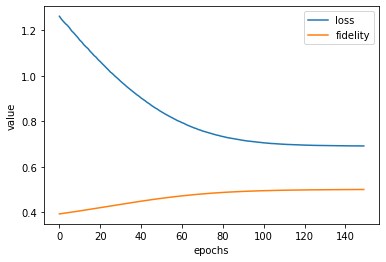

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_history = []
fidelity_history = []


# make it so that this is compiled
@tf.function
def train_step():
  # tape already previously defined, and only shown here for educational purposes
  with tf.GradientTape() as tape:
    loss_value = qmhl.qmhl(test_qhbm, target_states, target_counts)
  grads = tape.gradient(loss_value, test_qhbm.trainable_variables)
  optimizer.apply_gradients(zip(grads, test_qhbm.trainable_variables))
  return loss_value


def calc_fidelity():
  p0 = target_counts[0].numpy()
  p1 = target_counts[1].numpy()
  p = p0 + p1
  density_matrix = p1 / p * cirq.final_density_matrix(
      p1_circuits) + p0 / p * cirq.final_density_matrix(p1_circuits)
  return test_qhbm.fidelity(density_matrix)


def train(epochs):
  for epoch in tf.range(epochs):
    loss_value = train_step()
    loss_history.append(loss_value.numpy().mean())
    fidelity = calc_fidelity()
    fidelity_history.append(fidelity)
    if epoch % 10 == 0:
      print("Epoch {} finished".format(epoch))


# call the above function
train(epochs=150)

plt.ylabel("value")
plt.xlabel("epochs")
plt.plot(loss_history, label="loss")
plt.plot(fidelity_history, label="fidelity")
plt.legend()
plt.show()

### The solution

We have now, under the assumptions of a Bernoulli distribution with parameter $\theta$ for the classical component and an $R_x$ gate with parameter $\phi$ for the ansatz, found the best approximation to our target state $\sigma_D$. This allows to prepare multiple copies of the state, to use for further analysis. The values of the parameters are shown below. 

In [11]:
print([test_qhbm.trainable_variables[i].numpy() for i in range(2)])

[array([0.02003845], dtype=float32), array([-1.7836734], dtype=float32)]



# Appendix

## A. Bernoulli distribution

General Bernoulli equation: \\
$$p(x) = \alpha^x (1-\alpha)^{1-x}$$
Working towards the natural form:
\begin{align}
p(x) &= e^{x \log(\alpha)+\log(1-\alpha)^{1-x}} \\
&= e^{x \log\left(\frac{\alpha}{1-\alpha}\right)+\log(1-\alpha)} \\
&= e^{2\theta x-\log(1+e^{2\theta})} \\
\text{Wi}&\text{th } \theta = \frac{1}{2}\log \left( \frac{\alpha}{1-\alpha}\right) 
\end{align}

Plugging this in the definition of $\rho_\theta$:
\begin{align}
\rho_{\theta} &\equiv \sum_{x} p(x)|x\rangle\langle x| \\
&= p(0) |0\rangle\langle 0| + p(1) |1\rangle\langle 1| \\
&= e^{0-\log(1+e^{2\theta})} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} 
+ e^{\gamma-\log(1+e^{2\theta})} \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \\
&= \frac{1}{1+e^{2\theta}} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}
+ \frac{e^{{2\theta}}}{1+e^{2\theta}} \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \\
&= \frac{1}{1+e^2\theta} \begin{bmatrix} 1 & 0 \\ 0 & e^{2\theta} \end{bmatrix} \end{align}

Now to write it in the form of a spin $\frac{1}{2}$ particle:
\begin{align}
&= \frac{e^{-\theta}}{e^{-\theta}} * \frac{1}{1+e^2\theta} \begin{bmatrix} 1 & 0 \\ 0 & e^{2\theta} \end{bmatrix} \\
&= \frac{1}{e^{-\theta} + e^{\theta}}\begin{bmatrix}
    e^{-\theta} & 0 \\
    0 & e^{\theta}
\end{bmatrix}.
\end{align}